In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os

np.random.seed(42)
tf.random.set_seed(42)

In [15]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

print("Loading dataset...")
covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets

print("\nDataset Metadata:")
print(covertype.metadata)
print("\nVariable Information:")
print(covertype.variables)

Loading dataset...

Dataset Metadata:
{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (3

In [16]:
y = y.values.ravel() - 1

print(f"\nDataset loaded with {X.shape[0]} samples, {X.shape[1]} features, and {len(np.unique(y))} classes")

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

y_onehot = tf.keras.utils.to_categorical(y)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


Dataset loaded with 581012 samples, 54 features, and 7 classes
Training set: 464809 samples
Validation set: 116203 samples


In [17]:
def create_model_with_connections(input_shape, output_shape, units=32):
    inputs = Input(shape=(input_shape,))

    dense_layer1 = Dense(units, activation='relu')(inputs)

    skip_connection_source = dense_layer1

    dense_layer2 = Dense(units, activation='relu')(dense_layer1)

    dense_layer3 = Dense(units)(dense_layer2)

    # Add the residual connection
    residual_output = Add()([dense_layer3, dense_layer1])
    # Apply activation using a Dense layer with identity weights
    residual_output = Dense(units, activation='relu',
                           kernel_initializer='identity',
                           use_bias=False)(residual_output)

    dense_layer4 = Dense(units // 2, activation='relu')(residual_output)

    skip_projection = Dense(units // 2)(skip_connection_source)

    skip_connection_output = Add()([dense_layer4, skip_projection])
    # Apply activation using a Dense layer with identity weights
    skip_connection_output = Dense(units // 2, activation='relu',
                                  kernel_initializer='identity',
                                  use_bias=False)(skip_connection_output)

    outputs = Dense(output_shape, activation='softmax')(skip_connection_output)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = create_model_with_connections(input_dim, output_dim)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 54)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 32)             │          1,760 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 32)             │          1,056 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 32)             │          1,056 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 32)             │              0 │ dense_25[0][0],        │
│                           │                        │                │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 32)             │          1,024 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 16)             │            528 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 16)             │            528 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 16)             │              0 │ dense_27[0][0],        │
│                           │                        │                │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 16)             │            256 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 7)              │            119 │ dense_29[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,327 (24.71 KB)

 Trainable params: 6,327 (24.71 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
batch_size = 128
random_indices = np.random.choice(X_train.shape[0], batch_size, replace=False)
X_single_batch = X_train[random_indices]
y_single_batch = y_train[random_indices]

print(f"Single batch shape: {X_single_batch.shape}")

epochs = 400
history = model.fit(
    X_single_batch, y_single_batch,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val)
)

Single batch shape: (128, 54)
Epoch 1/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.0594 - loss: 2.3771 - val_accuracy: 0.0881 - val_loss: 2.2482
Epoch 2/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1250 - loss: 2.0932 - val_accuracy: 0.1666 - val_loss: 2.0965
Epoch 3/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2677 - loss: 1.9081 - val_accuracy: 0.2624 - val_loss: 1.9853
Epoch 4/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.3438 - loss: 1.7668 - val_accuracy: 0.3417 - val_loss: 1.8945
Epoch 5/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4990 - loss: 1.6471 - val_accuracy: 0.4052 - val_loss: 1.8124
Epoch 6/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6000 - loss: 1.5332 - val_accuracy: 0.4525 - val_loss: 1.7357
Epoch 7/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6573 - loss: 1.4301 - val_accuracy: 0.4754 - val_loss: 1.6676
Epoch 8/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6698 - loss: 1.3340 - val_accuracy:

Model saved to /content/residual_skip_model.h5
Now you can open this file with Netron app (https://netron.app/)


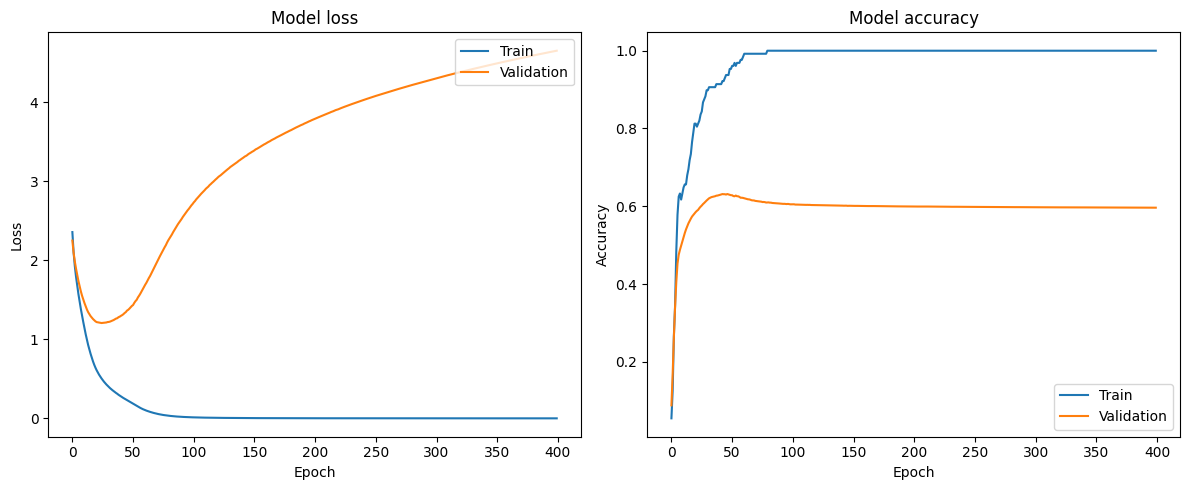

Model architecture diagram saved as 'model_diagram.png'


In [19]:
model.save('residual_skip_model.h5')
print(f"Model saved to {os.path.abspath('residual_skip_model.h5')}")
print("Now you can open this file with Netron app (https://netron.app/)")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

tf.keras.utils.plot_model(
    model,
    to_file='model_diagram.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96,
)
print("Model architecture diagram saved as 'model_diagram.png'")

In [20]:
train_loss, train_acc = model.evaluate(X_single_batch, y_single_batch, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])

print("\n--- FINAL RESULTS ---")
print(f"Number of parameters: {trainable_params}")
print(f"Final training loss: {train_loss:.4f}")
print(f"Final training accuracy: {train_acc:.4f}")
print(f"Final validation loss: {val_loss:.4f}")
print(f"Final validation accuracy: {val_acc:.4f}")


--- FINAL RESULTS ---
Number of parameters: 6327
Final training loss: 0.0002
Final training accuracy: 1.0000
Final validation loss: 4.6488
Final validation accuracy: 0.5964
